In [38]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import numpy as np
import sys
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath('../../'))

import utils.ml_util
importlib.reload(utils.ml_util)
from utils.ml_util import *

import utils.trading_util
importlib.reload(utils.trading_util)
from utils.trading_util import *

[*********************100%***********************]  1 of 1 completed


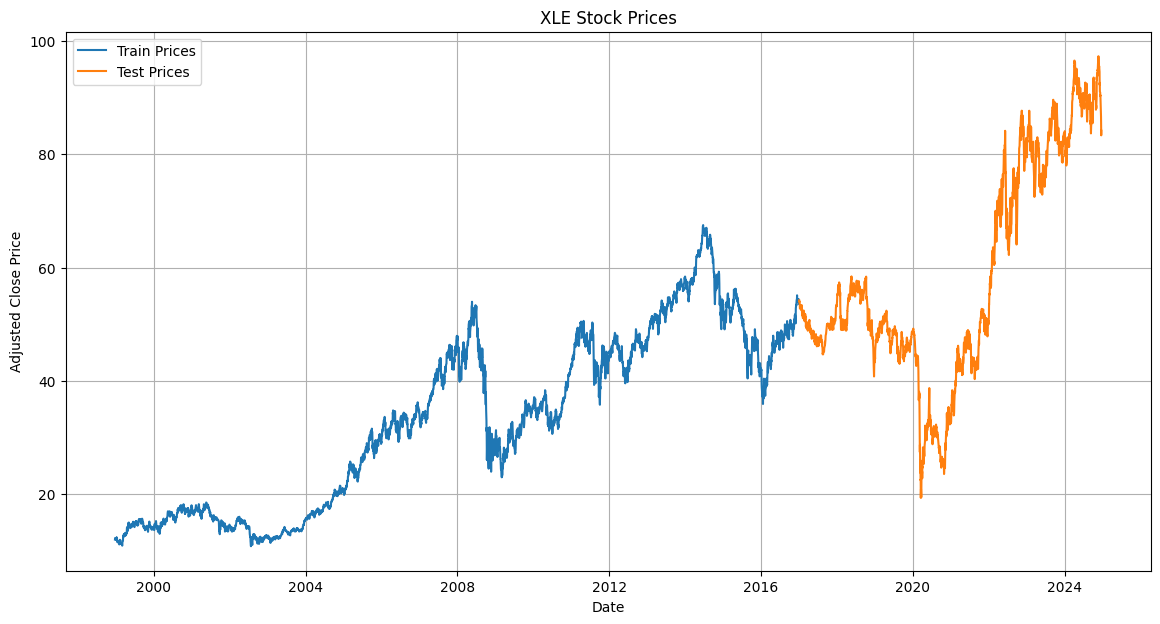

In [39]:
TKR = 'XLE'
MAX_HOLDING = 100
FEATURE_KERNEL_SIZES = [5, 10, 20, 50, 70, 100]
TEST_TRAIN_SPLIT = pd.Timestamp('2017-01-01')
TIME_EFFECT = 3

historic_prices = yf.download(TKR)['Adj Close']
train_prices, test_prices = historic_prices[TKR][:TEST_TRAIN_SPLIT].to_list(), historic_prices[TKR][TEST_TRAIN_SPLIT:].to_list()
plt.figure(figsize=(14, 7))
plt.plot(historic_prices[TKR][:TEST_TRAIN_SPLIT], label='Train Prices')
plt.plot(historic_prices[TKR][TEST_TRAIN_SPLIT:], label='Test Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title(f'{TKR} Stock Prices')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
outlook = []
for pos1 in range(len(train_prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (train_prices[pos1 + pos2] - train_prices[pos1]) * time_effect[TIME_EFFECT](MAX_HOLDING, pos2)
    outlook.append(ans / integrated_time_effect[TIME_EFFECT])
    
n_outlook = normalize_average(outlook, MAX_HOLDING * 3)

In [41]:
features = get_sma_sd_v(train_prices, FEATURE_KERNEL_SIZES, max(FEATURE_KERNEL_SIZES))
for pos in range(len(features)):
    features[pos] = features[pos][:-MAX_HOLDING - 1]
n_outlook = n_outlook[max(FEATURE_KERNEL_SIZES):]

x = np.array(transpose(features))
y = np.array(n_outlook)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

def create_model():
    inputs = tf.keras.layers.Input(shape=(len(FEATURE_KERNEL_SIZES) * 3,))
    
    x = tf.keras.layers.Dense(256, activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    residual_1 = x
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, residual_1])
    
    residual_2 = x
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Add()([x, residual_2])
    
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    outputs = tf.keras.layers.Dense(1, activation='tanh')(x)
    
    return tf.keras.models.Model(inputs, outputs)

model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='mean_absolute_error')

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 256)       │      4,864 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_20[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 512)       │    131,584 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_21[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256)       │    131,328 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_22[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 512)       │    131,584 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_23[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 512)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │    131,328 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_24[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │     32,896 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_25[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128)       │          0 │ batch_normalizat

 Total params: 579,841 (2.21 MB)

 Trainable params: 575,873 (2.20 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [43]:
model.fit(x=x_train, 
        y=y_train, 
        epochs=70, 
        validation_data=(x_test, y_test), 
    )

Epoch 1/70
109/109 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.6889 - val_loss: 0.5340
Epoch 2/70
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5886 - val_loss: 0.5487
Epoch 3/70
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5180 - val_loss: 0.3682
Epoch 4/70
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.4536 - val_loss: 0.3068
Epoch 5/70
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4053 - val_loss: 0.2871
Epoch 6/70
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3797 - val_loss: 0.3005
Epoch 7/70
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3608 - val_loss: 0.2889
Epoch 8/70
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3420 - val_loss: 0.2782
Epoch 9/70
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3354 - val_loss: 0.2670
Epoch 10/70
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3309 - val_loss: 0.2900
Epoch 11/70
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.3330 - val_loss: 0.2639
Epoch 12/70
109/109 ━━━━━━━━━━━━━━━━━━━━ 

In [44]:
features = get_sma_sd_v(test_prices, FEATURE_KERNEL_SIZES, max(FEATURE_KERNEL_SIZES))
test_prices = test_prices[max(FEATURE_KERNEL_SIZES) - 1:]

x = np.array(transpose(features))

p_outlook = model.predict(x)
p_outlook = [x[0] for x in p_outlook]

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [55]:
account = Account()
stock = Stock(TKR, test_prices[0])
MAX_TRANSACTION = 1

buy_positions = []
sell_positions = []
executed_sell_orders = []
executed_cover_orders = []

net_worth = []
min_balance = 0

for pos in range(len(test_prices)):
    stock.update_price(test_prices[pos])
    
    if p_outlook[pos] > 0.2:
        account.buy(stock, abs(MAX_TRANSACTION * p_outlook[pos]))
        buy_positions.append((pos, test_prices[pos]))
    elif p_outlook[pos] < -0.7:
        account.sell(stock, abs(MAX_TRANSACTION * p_outlook[pos]))
        sell_positions.append((pos, test_prices[pos]))
    
    net_worth.append(float(account.net_worth()))
    if account.balance < min_balance:
        min_balance = account.balance

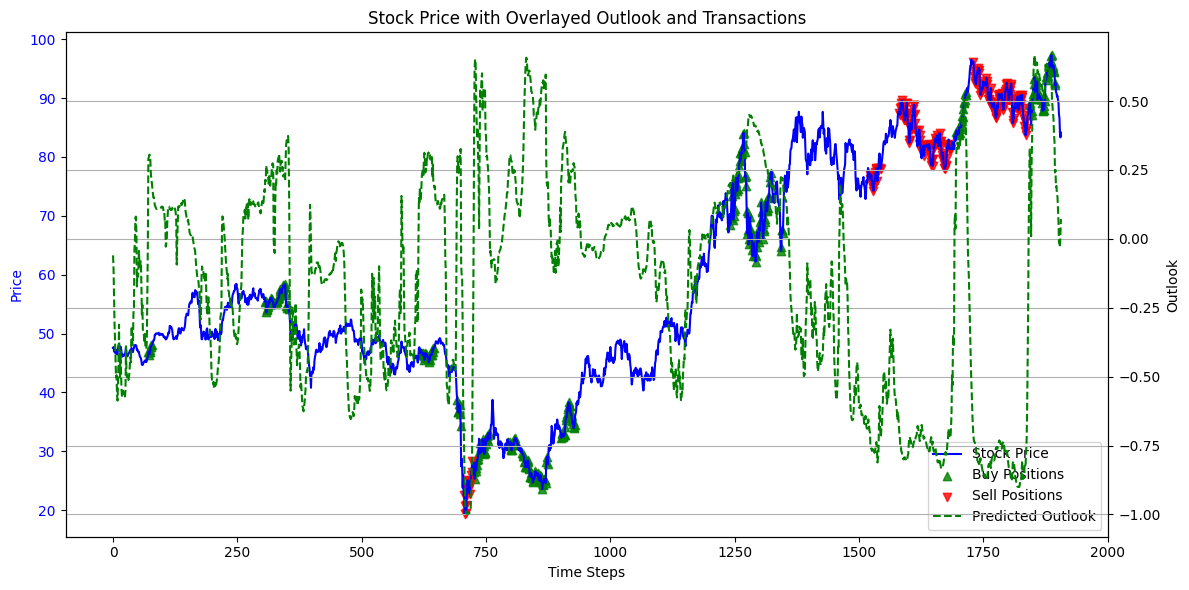

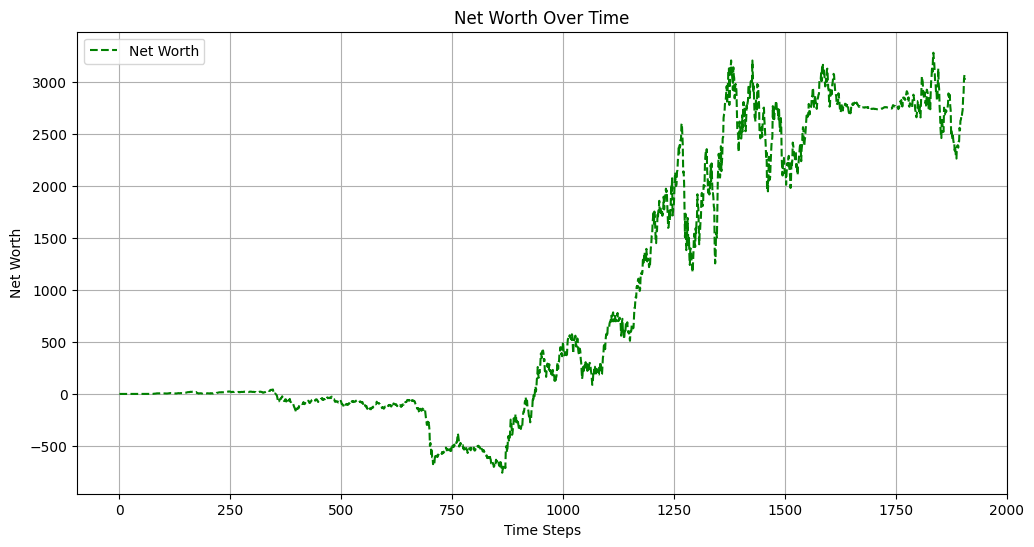

Balance: $7827.80
Net Worth: $3022.46
Total Profit: 74.55%
Holdings:
XLE: -57.11121368408203 shares
Stock Profit: 76.70%


In [56]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(range(len(test_prices)), test_prices, label="Stock Price", color="blue")
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

buy_x, buy_y = zip(*buy_positions) if buy_positions else ([], [])
ax1.scatter(buy_x, buy_y, label="Buy Positions", color="green", marker="^", alpha=0.8)

sell_x, sell_y = zip(*sell_positions) if sell_positions else ([], [])
ax1.scatter(sell_x, sell_y, label="Sell Positions", color="red", marker="v", alpha=0.8)

ax2 = ax1.twinx()
ax2.plot(range(len(p_outlook)), p_outlook, label="Predicted Outlook", color="green", linestyle="--")
ax2.set_ylabel("Outlook", color="black")
ax2.tick_params(axis="y", labelcolor="black")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="lower right")

plt.title("Stock Price with Overlayed Outlook and Transactions")
plt.grid()
plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(len(net_worth)), net_worth, label="Net Worth", color="green", linestyle="--")

plt.title("Net Worth Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Net Worth")
plt.legend()
plt.grid()

plt.show()

print(account)
print(f"Stock Profit: {(test_prices[-1] - test_prices[0]) / test_prices[0] * 100:.2f}%")